# **NLP Final Project**
### **Roman Urdu Word embeddings using word2vec**

**Muhammd Owais Alam Ansari - [21K-4182]**
<br>
**Faiz ur Rehman Khan - [21K-4188]**

### **Importing the required packages**

In [143]:
import numpy as np
import re 
import pandas as pd
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
import multiprocessing
from time import time
import os.path
import pickle
from gensim.test.utils import datapath
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd  
from gensim.models.callbacks import CallbackAny2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Loading the dataset**

In [145]:
df = pd.read_csv('/content/drive/MyDrive/NLPProject/chat_data.csv')


##**Exploratory Data Analysis**
**Preparing the text to train the model**

### **Shape of data**

In [146]:
df.shape

(237904, 3)

### **Have a look a data**

In [147]:
df.head()

,id,message,msgType
0,16,Sure Man,text
1,17,Hi,text
2,18,Hogaya,text
3,19,Han Sahi,text
4,22,Nope not,text


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237904 entries, 0 to 237903
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       237904 non-null  int64 
 1   message  237904 non-null  object
 2   msgType  237904 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.4+ MB


**Removing irrelevant column**

In [149]:
df = df.drop(['msgType'], axis=1)
df.head(5)

,id,message
0,16,Sure Man
1,17,Hi
2,18,Hogaya
3,19,Han Sahi
4,22,Nope not


### **Dataset contains some numbers and non-english characters. Therefore, Remove all non-english characters and make everything lowercase.**

In [150]:
df['cleanMsg'] = df['message'].str.replace('[^a-zA-Z]',' ').str.lower()

<ipython-input-150-7da6916cac2c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleanMsg'] = df['message'].str.replace('[^a-zA-Z]',' ').str.lower()


In [151]:
df.head()

,id,message,cleanMsg
0,16,Sure Man,sure man
1,17,Hi,hi
2,18,Hogaya,hogaya
3,19,Han Sahi,han sahi
4,22,Nope not,nope not


In [152]:
df[0:25]

,id,message,cleanMsg
0,16,Sure Man,sure man
1,17,Hi,hi
2,18,Hogaya,hogaya
3,19,Han Sahi,han sahi
4,22,Nope not,nope not
5,23,right,right
6,24,oook,oook
7,25,poppopopo,poppopopo
8,26,JIjis,jijis
9,27,Okayy,okayy


In [153]:
df['cleanMsg'].replace(' ', np.nan, inplace=True)

In [154]:
df.isnull().sum()

id             0
message        0
cleanMsg    4390
dtype: int64

###**Remove Null values**

In [155]:
df = df.dropna(subset=['cleanMsg'])

In [156]:
df[0:25]

,id,message,cleanMsg
0,16,Sure Man,sure man
1,17,Hi,hi
2,18,Hogaya,hogaya
3,19,Han Sahi,han sahi
4,22,Nope not,nope not
5,23,right,right
6,24,oook,oook
7,25,poppopopo,poppopopo
8,26,JIjis,jijis
9,27,Okayy,okayy


In [157]:
df.isnull().sum()

id          0
message     0
cleanMsg    0
dtype: int64

### **Removing the sentence with only single words because Word2Vec uses context words to learn the vector representation of a target word.**

In [158]:
df = df[df["cleanMsg"].apply(lambda x: len(x.split()) > 1)]
# df = df[df["cleanMsg"].apply(lambda x: len(x.split()) > 2)]

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173962 entries, 0 to 237903
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        173962 non-null  int64 
 1   message   173962 non-null  object
 2   cleanMsg  173962 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [160]:
df[0:25]

,id,message,cleanMsg
0,16,Sure Man,sure man
3,19,Han Sahi,han sahi
4,22,Nope not,nope not
11,29,ub lag,ub lag
12,30,raha hai,raha hai
15,41,mil aye,mil aye
26,63,Phonch gaya,phonch gaya
27,64,yahan bhi,yahan bhi
31,70,Dobara chala hai,dobara chala hai
32,71,Cs k sath,cs k sath


### **Dropping duplicate rows**


In [161]:
df['cleanMsg'].is_unique

False

In [162]:
duplicate_rows_df = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_df.shape)

Number of duplicate rows:  (0, 3)


In [163]:
df = df.drop_duplicates(subset=['cleanMsg'], keep='first')

In [164]:
df['cleanMsg'].is_unique

True

In [165]:
df.head()

,id,message,cleanMsg
0,16,Sure Man,sure man
3,19,Han Sahi,han sahi
4,22,Nope not,nope not
11,29,ub lag,ub lag
12,30,raha hai,raha hai


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134140 entries, 0 to 237903
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        134140 non-null  int64 
 1   message   134140 non-null  object
 2   cleanMsg  134140 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


### **Data Visualization**

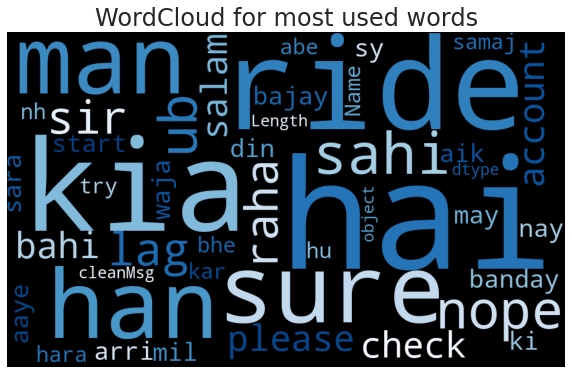

In [167]:
word_cloud = WordCloud(colormap='Blues',width=1000,height=600).generate(str(df["cleanMsg"]))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title("WordCloud for most used words", size = 24)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

Text(0.5, 1.0, '30 most frequent words')

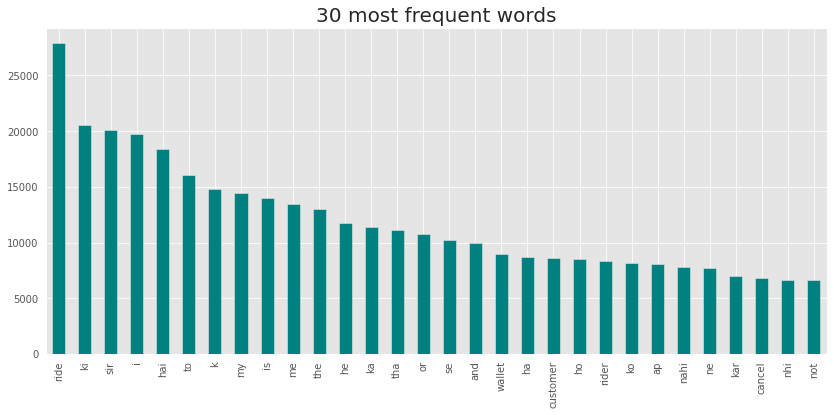

In [168]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df["cleanMsg"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "teal")
plt.title("30 most frequent words",size=20)

## **Model Training**

**Creating array list of text from data**

In [169]:
dataset = [i for i in df['cleanMsg']]
print (dataset[0:20])

['sure man', 'han sahi', 'nope not', 'ub lag', 'raha hai', 'mil aye', 'phonch gaya', 'yahan bhi', 'dobara chala hai', 'cs k sath', 'i need to ask something about', 'kaor zara', 'nahi aya', 'kia ogaua', 'okay hello  st', 'fpata nahi', 'idk bro', 'test tha', 'usk bd', 'p p']


#### **Tokenization of roman text**

In [170]:
roman_lines = list()
t = time()
if os.path.exists('/content/drive/MyDrive/NLPProject/romanTokTT.ob'):
   with open ('/content/drive/MyDrive/NLPProject/romanTokTT.ob', 'rb') as fp:
    roman_lines = pickle.load(fp)
    print('Roman tokens loaded from .ob file')
else:
  for line in dataset:
      # tokenize the text
      tokens = word_tokenize(line)
      tokens = [w.lower() for w in tokens]
      # remove puntuations
      table = str.maketrans('', '', string.punctuation)
      stripped = [w.translate(table) for w in tokens]
      # remove non alphabetic characters
      words = [word for word in stripped if word.isalpha()]
      roman_lines.append(words)

  with open('/content/drive/MyDrive/NLPProject/romanTokTT.ob', 'wb') as fp:
    pickle.dump(roman_lines, fp)
    
  print('Roman tokens created from file')
    
print('Time to load: {} mins'.format(round((time() - t) / 60, 2)))
print(roman_lines[0:5])

Roman tokens loaded from .ob file
Time to load: 0.03 mins
[['sure', 'man'], ['han', 'sahi'], ['nope', 'not'], ['ub', 'lag'], ['raha', 'hai']]


In [171]:
# Callback to print loss after each epoch.

class callback(CallbackAny2Vec):

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_begin(self, model):
        print("Epoch {} start.".format(self.epoch))

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        print("Epoch {} end.".format(self.epoch))
        print("") 
        self.epoch += 1

### **Train word2vec model on roman urdu text**

In [172]:
t = time()
if os.path.exists('/content/drive/MyDrive/NLPProject/my_model500eTTf.bin'):
  w2v_model = Word2Vec.load('/content/drive/MyDrive/NLPProject/my_model500eTTf.bin')
  print('Time to load the model: {} mins'.format(round((time() - t) / 60, 2)))
  
else:
  # w2v_model = Word2Vec(sentences=roman_lines, size=100, window=5, workers=4,
  #                      min_count=2, sg=0, iter=50, compute_loss=True, callbacks=[callback()]) #sg= 1:skip-gram 0:cbow
  

  # init word2vec
  w2v_model = Word2Vec(size=100, window=5, workers=4, min_count=2, sg=0)                   #sg= 1:skip-gram 0:cbow

  # build vocab
  w2v_model.build_vocab(roman_lines, progress_per=10000)

  # train the w2v model
  w2v_model.train(roman_lines, total_examples=w2v_model.corpus_count, epochs=500,
                  report_delay=1, compute_loss=True, callbacks=[callback()])

  temp_file = datapath("/content/drive/MyDrive/NLPProject/my_model500eTTf.bin")
  w2v_model.save(temp_file)
  print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

print(w2v_model)

Time to load the model: 0.0 mins
Word2Vec(vocab=18802, size=100, alpha=0.025)


**Using the vectors**

In [173]:
w2v_model['theek']

<ipython-input-173-705065881577>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_model['theek']


array([ 2.556298  , -1.5899674 ,  5.152026  , -1.4360673 , -0.8246735 ,
       -0.469423  , -0.36778715, -1.6391068 , -3.4034185 ,  5.7208586 ,
        3.4396634 , -1.7863203 , -0.63159543, -0.26678693,  2.1361992 ,
       -1.4443055 ,  3.7783105 ,  3.1483712 , -0.38099596,  4.323444  ,
        1.2859876 ,  3.1071246 ,  1.8443588 , -0.16635017,  1.4996445 ,
        0.6876709 ,  4.9236283 ,  3.0735302 ,  4.8310175 , -0.7834121 ,
       -0.79810005,  5.998676  ,  0.42858675,  2.5076818 , -0.7340251 ,
        0.2505676 , -4.8435755 ,  3.7187881 , -1.0538543 , -1.8349273 ,
        1.9150243 ,  1.0013913 , -1.4076318 , -4.813232  ,  1.5950863 ,
        1.3550221 ,  2.3762631 , -0.182756  , -1.8272729 , -0.4110854 ,
        0.83119184,  1.889701  ,  0.19091095, -4.5813956 , -0.51177806,
       -1.1392713 ,  1.6051753 , -2.2638335 , -0.51136833,  0.96551186,
        2.822236  ,  3.3239486 , -0.60430896, -2.443986  , -1.4446427 ,
       -4.2646275 ,  0.29170498, -0.56578106, -2.4792361 ,  0.22

In [174]:
w2v_model['kha']

<ipython-input-174-e44ff4da41b5>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_model['kha']


array([ 5.8478985 ,  1.24048   , -1.9604521 , -0.5735084 ,  1.7843504 ,
       -0.8653555 ,  0.690115  ,  0.6188991 , -1.2834879 , -3.0977721 ,
       -2.4501085 ,  4.314511  , -1.3940088 ,  3.0433245 , -2.2977798 ,
        2.4516637 , -0.9085602 ,  4.3992257 , -3.293119  ,  0.9944951 ,
        0.9336117 ,  0.29237306,  4.238414  ,  3.7906637 ,  2.2357657 ,
        0.49784413,  3.530291  ,  1.708084  , -0.12239515, -2.5898497 ,
        2.3548372 ,  2.2508695 ,  3.0181859 ,  3.6631114 , -3.1163678 ,
       -0.76672524,  1.3354719 , -2.1906898 , -0.21939428,  0.6937557 ,
       -1.1596248 , -0.12326095,  1.3104814 , -0.42805025,  2.5523136 ,
        4.7974863 , -2.0624182 , -1.9202731 , -3.0890763 ,  0.39494368,
       -1.1264522 , -4.166278  ,  0.27426302,  2.845719  ,  2.3210638 ,
       -0.2715628 , -4.413865  ,  4.8454328 ,  1.8228731 ,  6.2158804 ,
        3.1017163 ,  0.35449323,  1.1711389 , -1.240841  ,  2.3083842 ,
       -0.25622037, -3.1561294 , -0.2818382 , -4.346975  , -3.71

### **Testing the model**

In [175]:
w2v_model.wv.most_similar("theek")

[('sahi', 0.8442927598953247),
 ('thek', 0.7493808269500732),
 ('thk', 0.6290050745010376),
 ('theak', 0.6219216585159302),
 ('thik', 0.5971509218215942),
 ('durust', 0.5871020555496216),
 ('update', 0.570072591304779),
 ('tekh', 0.5580251812934875),
 ('clear', 0.5523952841758728),
 ('sahe', 0.5412688255310059)]

In [176]:
w2v_model.wv.most_similar("salam")

[('assalam', 0.7505413889884949),
 ('aslam', 0.6945579051971436),
 ('assalamualaikum', 0.6887892484664917),
 ('aoa', 0.6494870185852051),
 ('asalam', 0.6482506394386292),
 ('salaam', 0.6341894268989563),
 ('sir', 0.5868409872055054),
 ('asslam', 0.577566385269165),
 ('alaikum', 0.5706593990325928),
 ('sallam', 0.5616801381111145)]

In [177]:
w2v_model.wv.most_similar("nhi")

[('ni', 0.9428904056549072),
 ('nai', 0.9392019510269165),
 ('nh', 0.9224916100502014),
 ('nhe', 0.9184689521789551),
 ('nahi', 0.9036053419113159),
 ('nae', 0.8649413585662842),
 ('nhn', 0.8106951117515564),
 ('nahe', 0.7856118679046631),
 ('nii', 0.6588805317878723),
 ('nehi', 0.6207378506660461)]

In [178]:
w2v_model.wv.most_similar("zyada")

[('ziada', 0.8649775385856628),
 ('zada', 0.7359161376953125),
 ('ziyada', 0.7294439077377319),
 ('zayada', 0.664994478225708),
 ('zyda', 0.63858562707901),
 ('zaida', 0.6143780946731567),
 ('zayda', 0.5567811131477356),
 ('zeyada', 0.5433523654937744),
 ('kam', 0.5216171145439148),
 ('kum', 0.5210303664207458)]

In [179]:
w2v_model.wv.most_similar("bhai")

[('bahi', 0.7423927783966064),
 ('yar', 0.6869595050811768),
 ('janab', 0.6550467610359192),
 ('sir', 0.6414533257484436),
 ('boss', 0.5797358751296997),
 ('yaar', 0.5104833245277405),
 ('yr', 0.4869323968887329),
 ('bhaii', 0.4696558713912964),
 ('sar', 0.4441676139831543),
 ('bhuj', 0.44068485498428345)]

In [180]:
w2v_model.wv.most_similar("sai")

[('sae', 0.5883541703224182),
 ('se', 0.5279848575592041),
 ('thek', 0.5098848938941956),
 ('sa', 0.49759674072265625),
 ('sy', 0.4930087924003601),
 ('sahi', 0.48299500346183777),
 ('theek', 0.481913685798645),
 ('theak', 0.4791945815086365),
 ('say', 0.4717242419719696),
 ('tekh', 0.4176627993583679)]

**Cosine Similarity**

In [181]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity (model,word1,word2):
  cos_sim = dot(model.wv[word1], model.wv[word2])/(norm(model.wv[word1])*norm(model.wv[word2]))
  return cos_sim


In [182]:
cosine_similarity(w2v_model,'kaise', 'kese')

0.6785345

In [183]:
w2v_model.wv.similarity('kaise', 'kese')

0.6785345

In [184]:
w2v_model.wv.similarity('nhi', 'nahi')

0.90360534

## **Visualization**

In [185]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 100 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


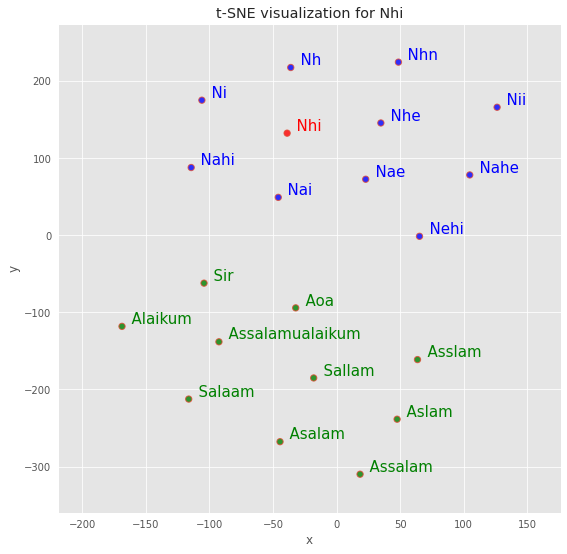

In [186]:
tsnescatterplot(w2v_model, 'nhi', [i[0] for i in w2v_model.wv.most_similar(positive=["salam"])])